# **1. Eksplorasi Data**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## **1.1 Memuat Data**

In [ ]:
data = pd.read_csv('/content/ai4i2020.csv')

## **1.2 Memeriksa Informasi Awal Data**

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

## **1.3 Memeriksa Nilai Yang Hilang**

In [ ]:
print("Missing values in each column:\n", data.isnull().sum())

Missing values in each column:
 UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


## **1.4 Menghapus Duplikasi**

In [ ]:
data.drop_duplicates(inplace=True)

## **1.5 Informasi Statistik Deskriptif Data**

In [ ]:
print("Summary statistics:\n", data.describe())

Summary statistics:
                UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]  Machine failure  \
count            10000.000000  10000.000000     10000.000000     10000.000000   
mean              1538.776100     39.986910       107.951000         0.033900   
std                179.284096      9.968934        63.654147         0.180981   
min               1168.000000      3.80000

## **1.6 Mendistribusikan Nilai pada kolom "Type"**

In [ ]:
print("Value counts for 'Type':\n", data['Type'].value_counts())

Value counts for 'Type':
 Type
L    6000
M    2997
H    1003
Name: count, dtype: int64


<ipython-input-13-d50369f1542c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type_counts.index, y=type_counts.values, palette='viridis')


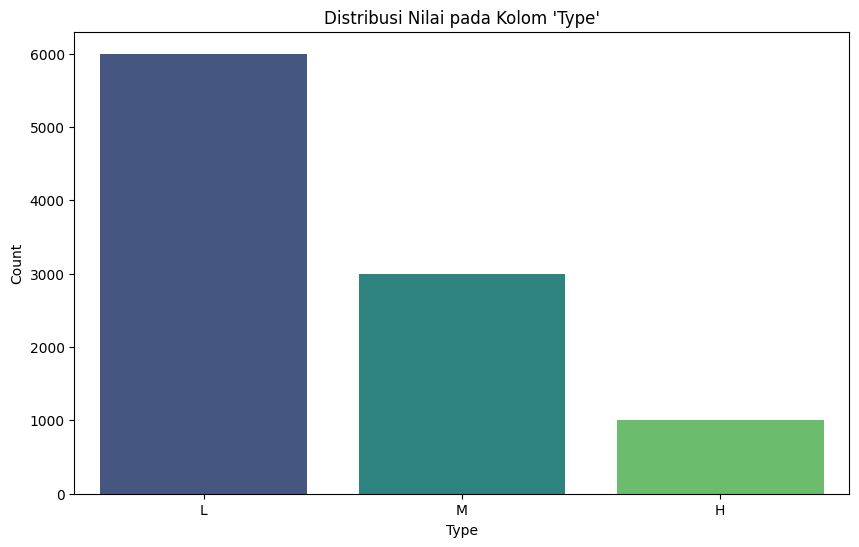

In [ ]:
type_counts = data['Type'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=type_counts.index, y=type_counts.values, palette='viridis')
plt.title("Distribusi Nilai pada Kolom 'Type'")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()

## **1.7 Mendistribusikan Kegagalan Mesin Berdasarkan Type**

In [81]:
failure_counts = data.groupby(['Type', 'Machine failure']).size().reset_index(name='count')
print(failure_counts)

  Type  Machine failure  count
0    H                0    982
1    H                1     21
2    L                0   5765
3    L                1    235
4    M                0   2914
5    M                1     83


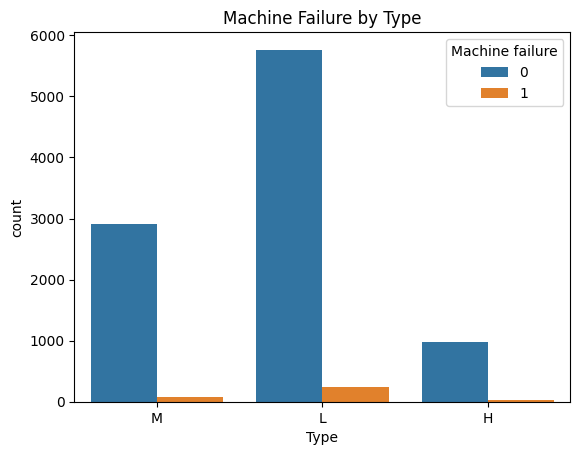

In [ ]:
sns.countplot(x='Type', hue='Machine failure', data=data)
plt.title("Machine Failure by Type")
plt.show()

# **2. Persiapan Data untuk Model**

## **2.1 Pemisah Fitur dan Target**

In [ ]:
X = data.drop(['UDI', 'Product ID', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)
y = data['Machine failure']

## **2.2 Preprocessing dan Pembentukan Model (Random Forest & Gradient Boosting)**

In [ ]:
numeric_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
categorical_features = ['Type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

gb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

## **2.3 Pemisahan Data untuk Pelatihan dan Pengujian**

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## **2.4 Pelatihan Model Random Forest**

In [ ]:
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Air temperature [K]',
                                                   'Process temperature [K]',
                                                   'Rotational speed [rpm]',
                                                   'Torque [Nm]',
                                                   'Tool wear [min]']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Type'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

## **2.5 Pelatihan Model Gradient Boosting**

In [ ]:
gb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Air temperature [K]',
                                                   'Process temperature [K]',
                                                   'Rotational speed [rpm]',
                                                   'Torque [Nm]',
                                                   'Tool wear [min]']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Type'])])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

# **3. Hasil dan Evaluasi**

## **3.1 Fungsi Evaluasi Model**

In [ ]:
def evaluate_model(model, X_val, y_val, X_test, y_test):
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    print("Validation Set Classification Report:\n", classification_report(y_val, y_val_pred))
    print("Validation Set Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
    val_roc_auc = roc_auc_score(y_val, y_val_proba)
    print(f'\nValidation ROC-AUC score: {val_roc_auc} \n')

    print("Test Set Classification Report:\n", classification_report(y_test, y_test_pred))
    print("Test Set Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
    test_roc_auc = roc_auc_score(y_test, y_test_proba)
    print(f'\nTest ROC-AUC score: {test_roc_auc} \n')

    cv_scores = cross_val_score(model, X, y, cv=5)
    print(f'Cross-validation scores: {cv_scores}')
    print(f'Mean cross-validation score: {cv_scores.mean()}')

## **3.2 Evaluasi Model Tanpa Tuning**

### **a. Model Random Forest**

In [ ]:
print("Evaluasi model Random Forest tanpa tuning:")
evaluate_model(rf_model, X_val, y_val, X_test, y_test)

Evaluasi model Random Forest tanpa tuning:
Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1939
           1       0.95      0.57      0.71        61

    accuracy                           0.99      2000
   macro avg       0.97      0.79      0.85      2000
weighted avg       0.99      0.99      0.98      2000

Validation Set Confusion Matrix:
 [[1937    2]
 [  26   35]]

Validation ROC-AUC score: 0.9372923342267013 

Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.92      0.51      0.66        68

    accuracy                           0.98      2000
   macro avg       0.95      0.76      0.83      2000
weighted avg       0.98      0.98      0.98      2000

Test Set Confusion Matrix:
 [[1929    3]
 [  33   35]]

Test ROC-AUC score: 0.9835890878090365 

Cross-validation scores: 

### **b. Model Gradient Boosting**

In [ ]:
print("Evaluasi model Gradient Boosting tanpa tuning:")
evaluate_model(gb_model, X_val, y_val, X_test, y_test)

Evaluasi model Gradient Boosting tanpa tuning:
Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1939
           1       0.80      0.66      0.72        61

    accuracy                           0.98      2000
   macro avg       0.89      0.83      0.86      2000
weighted avg       0.98      0.98      0.98      2000

Validation Set Confusion Matrix:
 [[1929   10]
 [  21   40]]

Validation ROC-AUC score: 0.9598829885271265 

Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.84      0.68      0.75        68

    accuracy                           0.98      2000
   macro avg       0.91      0.84      0.87      2000
weighted avg       0.98      0.98      0.98      2000

Test Set Confusion Matrix:
 [[1923    9]
 [  22   46]]

Test ROC-AUC score: 0.9858041042503958 

Cross-validation scor

# **4. Tuning Model**

In [ ]:
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_depth': [None, 10, 20, 30]
}

param_grid_gb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}

grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy')
grid_search_gb = GridSearchCV(gb_model, param_grid_gb, cv=5, scoring='accuracy')

grid_search_rf.fit(X_train, y_train)
grid_search_gb.fit(X_train, y_train)

print(f'Best parameters for Random Forest: {grid_search_rf.best_params_}')
print(f'Best parameters for Gradient Boosting: {grid_search_gb.best_params_}')

best_rf_model = grid_search_rf.best_estimator_
best_gb_model = grid_search_gb.best_estimator_

Best parameters for Random Forest: {'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__n_estimators': 100}
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}


## **4.1 Evaluasi Model dengan Tuning**

### **a. Model Random Forest**

In [ ]:
print("Evaluasi model Random Forest dengan tuning:")
evaluate_model(best_rf_model, X_val, y_val, X_test, y_test)

Evaluasi model Random Forest dengan tuning:
Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1939
           1       0.88      0.57      0.69        61

    accuracy                           0.98      2000
   macro avg       0.93      0.79      0.84      2000
weighted avg       0.98      0.98      0.98      2000

Validation Set Confusion Matrix:
 [[1934    5]
 [  26   35]]

Validation ROC-AUC score: 0.9459286940200711 

Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.91      0.57      0.70        68

    accuracy                           0.98      2000
   macro avg       0.95      0.79      0.85      2000
weighted avg       0.98      0.98      0.98      2000

Test Set Confusion Matrix:
 [[1928    4]
 [  29   39]]

Test ROC-AUC score: 0.9851723298014857 

Cross-validation scores:

### **b. Model Gradient Boosting**

In [ ]:
print("Evaluasi model Gradient Boosting dengan tuning:")
evaluate_model(best_gb_model, X_val, y_val, X_test, y_test)

Evaluasi model Gradient Boosting dengan tuning:
Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1939
           1       0.80      0.67      0.73        61

    accuracy                           0.98      2000
   macro avg       0.90      0.83      0.86      2000
weighted avg       0.98      0.98      0.98      2000

Validation Set Confusion Matrix:
 [[1929   10]
 [  20   41]]

Validation ROC-AUC score: 0.9488159352040514 

Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.88      0.72      0.79        68

    accuracy                           0.99      2000
   macro avg       0.93      0.86      0.89      2000
weighted avg       0.99      0.99      0.99      2000

Test Set Confusion Matrix:
 [[1925    7]
 [  19   49]]

Test ROC-AUC score: 0.9816176470588236 

Cross-validation sco

# **5. Visualisasi Hasil Model**

## **5.1 ROC Curve**


ROC Curve for each model:


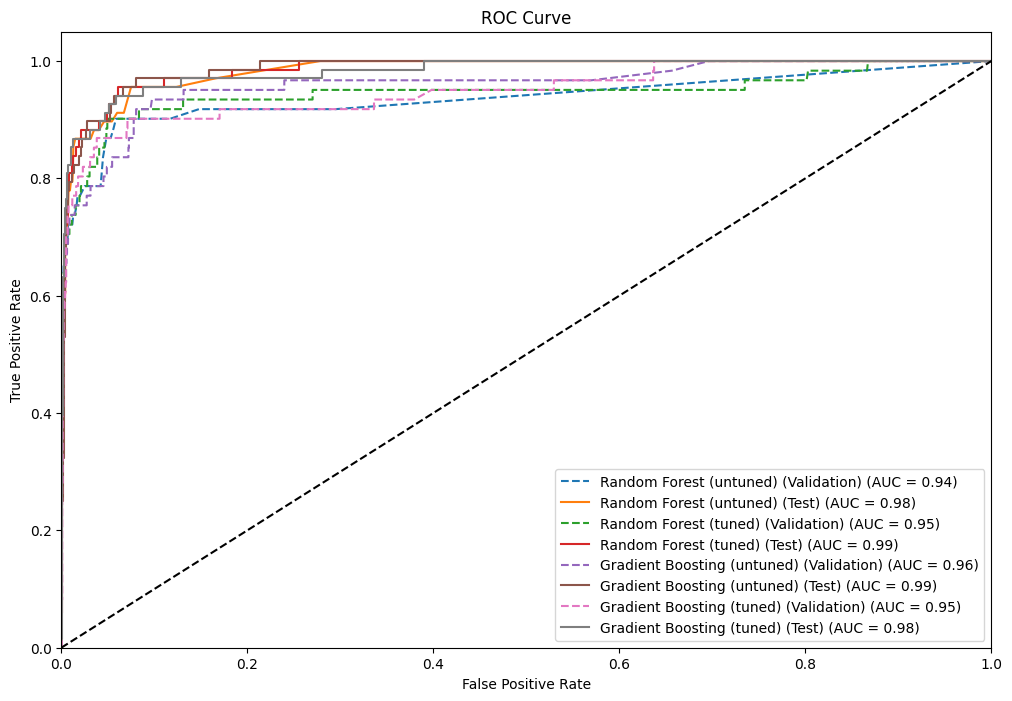

In [ ]:
def plot_roc_curve(models, X_val, y_val, X_test, y_test):
    plt.figure(figsize=(12, 8))

    for name, model in models.items():
        y_val_proba = model.predict_proba(X_val)[:, 1]
        fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
        roc_auc_val = auc(fpr_val, tpr_val)

        y_test_proba = model.predict_proba(X_test)[:, 1]
        fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
        roc_auc_test = auc(fpr_test, tpr_test)

        plt.plot(fpr_val, tpr_val, linestyle='--', label=f'{name} (Validation) (AUC = {roc_auc_val:.2f})')
        plt.plot(fpr_test, tpr_test, label=f'{name} (Test) (AUC = {roc_auc_test:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

models = {
    'Random Forest (untuned)': rf_model,
    'Random Forest (tuned)': best_rf_model,
    'Gradient Boosting (untuned)': gb_model,
    'Gradient Boosting (tuned)': best_gb_model
}

print("\nROC Curve for each model:")
plot_roc_curve(models, X_val, y_val, X_test, y_test)

## **5.2 Precision-Recall Curve**


Precision-Recall Curve for each model:


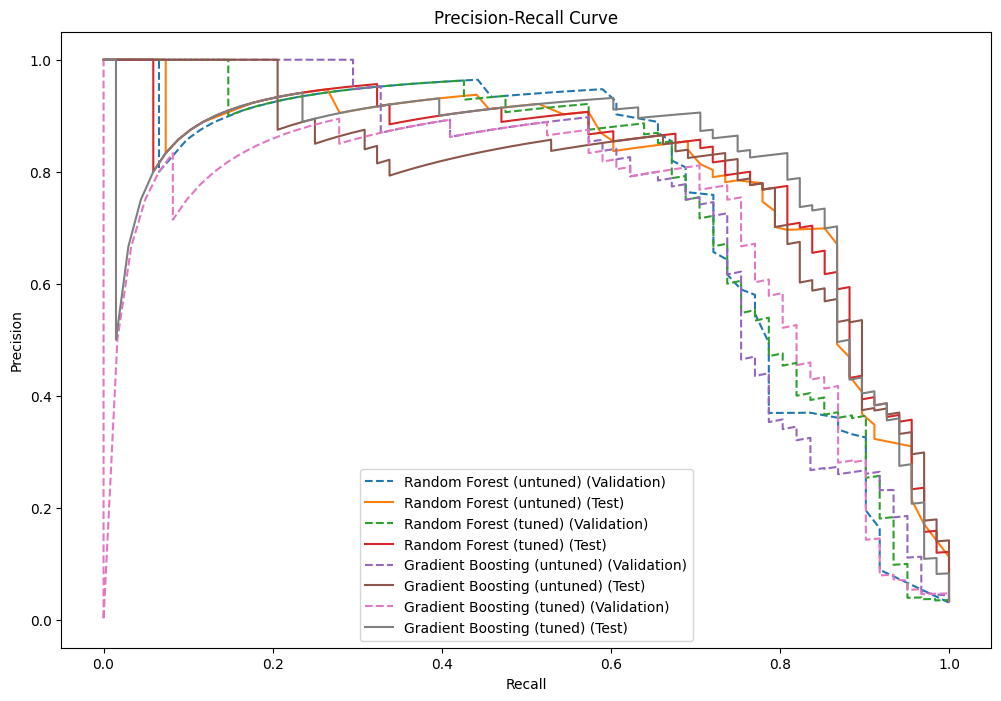

In [ ]:
def plot_precision_recall_curve(models, X_val, y_val, X_test, y_test):
    plt.figure(figsize=(12, 8))

    for name, model in models.items():
        y_val_proba = model.predict_proba(X_val)[:, 1]
        precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_proba)

        y_test_proba = model.predict_proba(X_test)[:, 1]
        precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)

        plt.plot(recall_val, precision_val, linestyle='--', label=f'{name} (Validation)')
        plt.plot(recall_test, precision_test, label=f'{name} (Test)')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

print("\nPrecision-Recall Curve for each model:")
plot_precision_recall_curve(models, X_val, y_val, X_test, y_test)

# **6. Hasil Analisis dan Kesimpulan**

## **6.1 Hasil Analisis Tanpa Tuning**

### **a. Model Random Forest**

- **Validation Set:**
  - Precision untuk kelas 0: 0.99
  - Recall untuk kelas 0: 1.00
  - Precision untuk kelas 1: 0.95
  - Recall untuk kelas 1: 0.57
  - Akurasi: 0.99
  - Macro average F1-score: 0.85
  - Weighted average F1-score: 0.98
  - ROC-AUC score: 0.9373
- **Test Set:**
  - Precision untuk kelas 0: 0.98
  - Recall untuk kelas 0: 1.00
  - Precision untuk kelas 1: 0.92
  - Recall untuk kelas 1: 0.51
  - Akurasi: 0.98
  - Macro average F1-score: 0.83
  - Weighted average F1-score: 0.98
  - ROC-AUC score: 0.9836
- **Cross-validation:**
  - Scores: [0.975, 0.9725, 0.5635, 0.971, 0.9805]
  - Mean score: 0.8925

- **Hasil:**
  - Model ini menunjukkan performa yang sangat baik untuk kelas 0 namun kurang baik untuk kelas 1, terutama pada recall
  - Cross-validation menunjukkan variabilitas yang sangat tinggi, menunjukkan bahwa model ini mungkin tidak terlalu stabil pada data yang berbeda

### **b. Model Gradient Boosting**

- **Validation Set:**
  - Precision untuk kelas 0: 0.99
  - Recall untuk kelas 0: 0.99
  - Precision untuk kelas 1: 0.80
  - Recall untuk kelas 1: 0.66
  - Akurasi: 0.98
  - Macro average F1-score: 0.86
  - Weighted average F1-score: 0.98
  - ROC-AUC score: 0.9599
- **Test Set:**
  - Precision untuk kelas 0: 0.99
  - Recall untuk kelas 0: 1.00
  - Precision untuk kelas 1: 0.84
  - Recall untuk kelas 1: 0.68
  - Akurasi: 0.98
  - Macro average F1-score: 0.87
  - Weighted average F1-score: 0.98
  - ROC-AUC score: 0.9858
- **Cross-validation:**
  - Scores: [0.9775, 0.9745, 0.5425, 0.9765, 0.982]
  - Mean score: 0.8906
- **Hasil:**
  - Model ini memiliki performa yang lebih seimbang dibandingkan Random Forest tanpa tuning, terutama dalam menangani kelas 1.
  - Variabilitas dalam cross-validation masih tinggi, namun secara umum menunjukkan performa yang lebih konsisten.


## **6.2 Hasil Analisis Dengan Tuning**

### **a. Model Random Forest**

- **Validation Set:**
  - Precision untuk kelas 0: 0.99
  - Recall untuk kelas 0: 1.00
  - Precision untuk kelas 1: 0.88
  - Recall untuk kelas 1: 0.57
  - Akurasi: 0.98
  - Macro average F1-score: 0.84
  - Weighted average F1-score: 0.98
  - ROC-AUC score: 0.9459
- **Test Set:**
  - Precision untuk kelas 0: 0.99
  - Recall untuk kelas 0: 1.00
  - Precision untuk kelas 1: 0.91
  - Recall untuk kelas 1: 0.57
  - Akurasi: 0.98
  - Macro average F1-score: 0.85
  - Weighted average F1-score: 0.98
  - ROC-AUC score: 0.9852
- **Cross-validation:**
  - Scores: [0.9745, 0.9745, 0.5685, 0.972, 0.9815]
  - Mean score: 0.8942

- **Hasil:**
  - Setelah tuning, performa model Random Forest meningkat sedikit, terutama pada recall kelas 1.
  - Meskipun tuning memperbaiki beberapa aspek, variabilitas cross-validation masih tinggi.

### **b. Model Gradient Boosting**

- **Validation Set:**
  - Precision untuk kelas 0: 0.99
  - Recall untuk kelas 0: 0.99
  - Precision untuk kelas 1: 0.80
  - Recall untuk kelas 1: 0.67
  - Akurasi: 0.98
  - Macro average F1-score: 0.86
  - Weighted average F1-score: 0.98
  - ROC-AUC score: 0.9488
- **Test Set:**
  - Precision untuk kelas 0: 0.99
  - Recall untuk kelas 0: 1.00
  - Precision untuk kelas 1: 0.88
  - Recall untuk kelas 1: 0.72
  - Akurasi: 0.99
  - Macro average F1-score: 0.89
  - Weighted average F1-score: 0.99
  - ROC-AUC score: 0.9816
- **Cross-validation:**
  - Scores: [0.9755, 0.9745, 0.582, 0.965, 0.9845]
  - Mean score: 0.8963
- **Hasil:**
  - Setelah tuning, performa model Gradient Boosting meningkat signifikan, terutama dalam hal recall untuk kelas 1.
  - ROC-AUC score yang tinggi dan lebih konsisten menunjukkan bahwa model ini robust dan stabil.



## **6.3 Kesimpulan**

**Random Forest Tanpa Tuning:**
- Sangat baik dalam memprediksi kelas mayoritas (0) namun kurang baik dalam memprediksi kelas minoritas (1).
- Variabilitas cross-validation menunjukkan performa yang tidak stabil.

**Gradient Boosting Tanpa Tuning:**
- Lebih seimbang dalam memprediksi kedua kelas dibandingkan Random Forest tanpa tuning.
- Meskipun masih memiliki variabilitas tinggi dalam cross-validation, performanya lebih konsisten.

**Random Forest dengan Tuning:**
- Peningkatan performa setelah tuning tidak signifikan.
- Masih menunjukkan variabilitas tinggi dalam cross-validation.

**Gradient Boosting dengan Tuning:**
- Model terbaik dari semua yang diuji, dengan performa yang seimbang dan robust.
- Variabilitas dalam cross-validation menurun, menunjukkan performa yang lebih stabil.


# **7. Rekomendasi**

- Gradient Boosting dengan Tuning adalah pilihan terbaik untuk model yang seimbang, robust, dan stabil.
- Jika membutuhkan model yang lebih cepat, Random Forest dengan Tuning bisa menjadi pilihan alternatif meskipun performanya sedikit di bawah Gradient Boosting.
